# Project Title Here

**Names**: Group member names here

You can delete and add as many code blocks as you like or change the formatting.

## 1. Introduction

## 2. Dataset Discussion

## 3. Dataset Cleaning and Exploration

The following code performs data cleaning and exploratory data analysis on the original dataset. The goals for this part of the project include the following.

1. Detect missing values and see whether we need to drop or replace the missing values.
2. Create scatterplots of each pair of numerical values and see whether we can identify any outliers


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Read the dataframe
df = pd.read_csv("student_math_clean.csv")
df.head(5)

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,10


### Subset the data
1. Only include 'GP' in the school
2. Assign Letter grade to final grade

In [4]:
# Identify Missing values
df_subset = df[df['school'] == 'GP']
quality_map = {'low': 0, 'medium': 1, 'high': 2}

bins = [0,9,13,15,17,20]
labels=['F','C','B','A','A+']
df_subset['letter_grade'] = pd.cut(df_subset['final_grade'], bins=bins, labels=labels, include_lowest=True)

print(df_subset.isnull().any().any())

False


/var/folders/2p/r7m1s3617sn4kbm4c6f8wct80000gn/T/ipykernel_45204/1179701445.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['letter_grade'] = pd.cut(df_subset['final_grade'], bins=bins, labels=labels, include_lowest=True)


In [6]:
df_subset.to_csv("../../letter_grade.csv")

### Missing Values Results 
1. As is indicated in the answer above, there are no missing values in this particular dataset. 

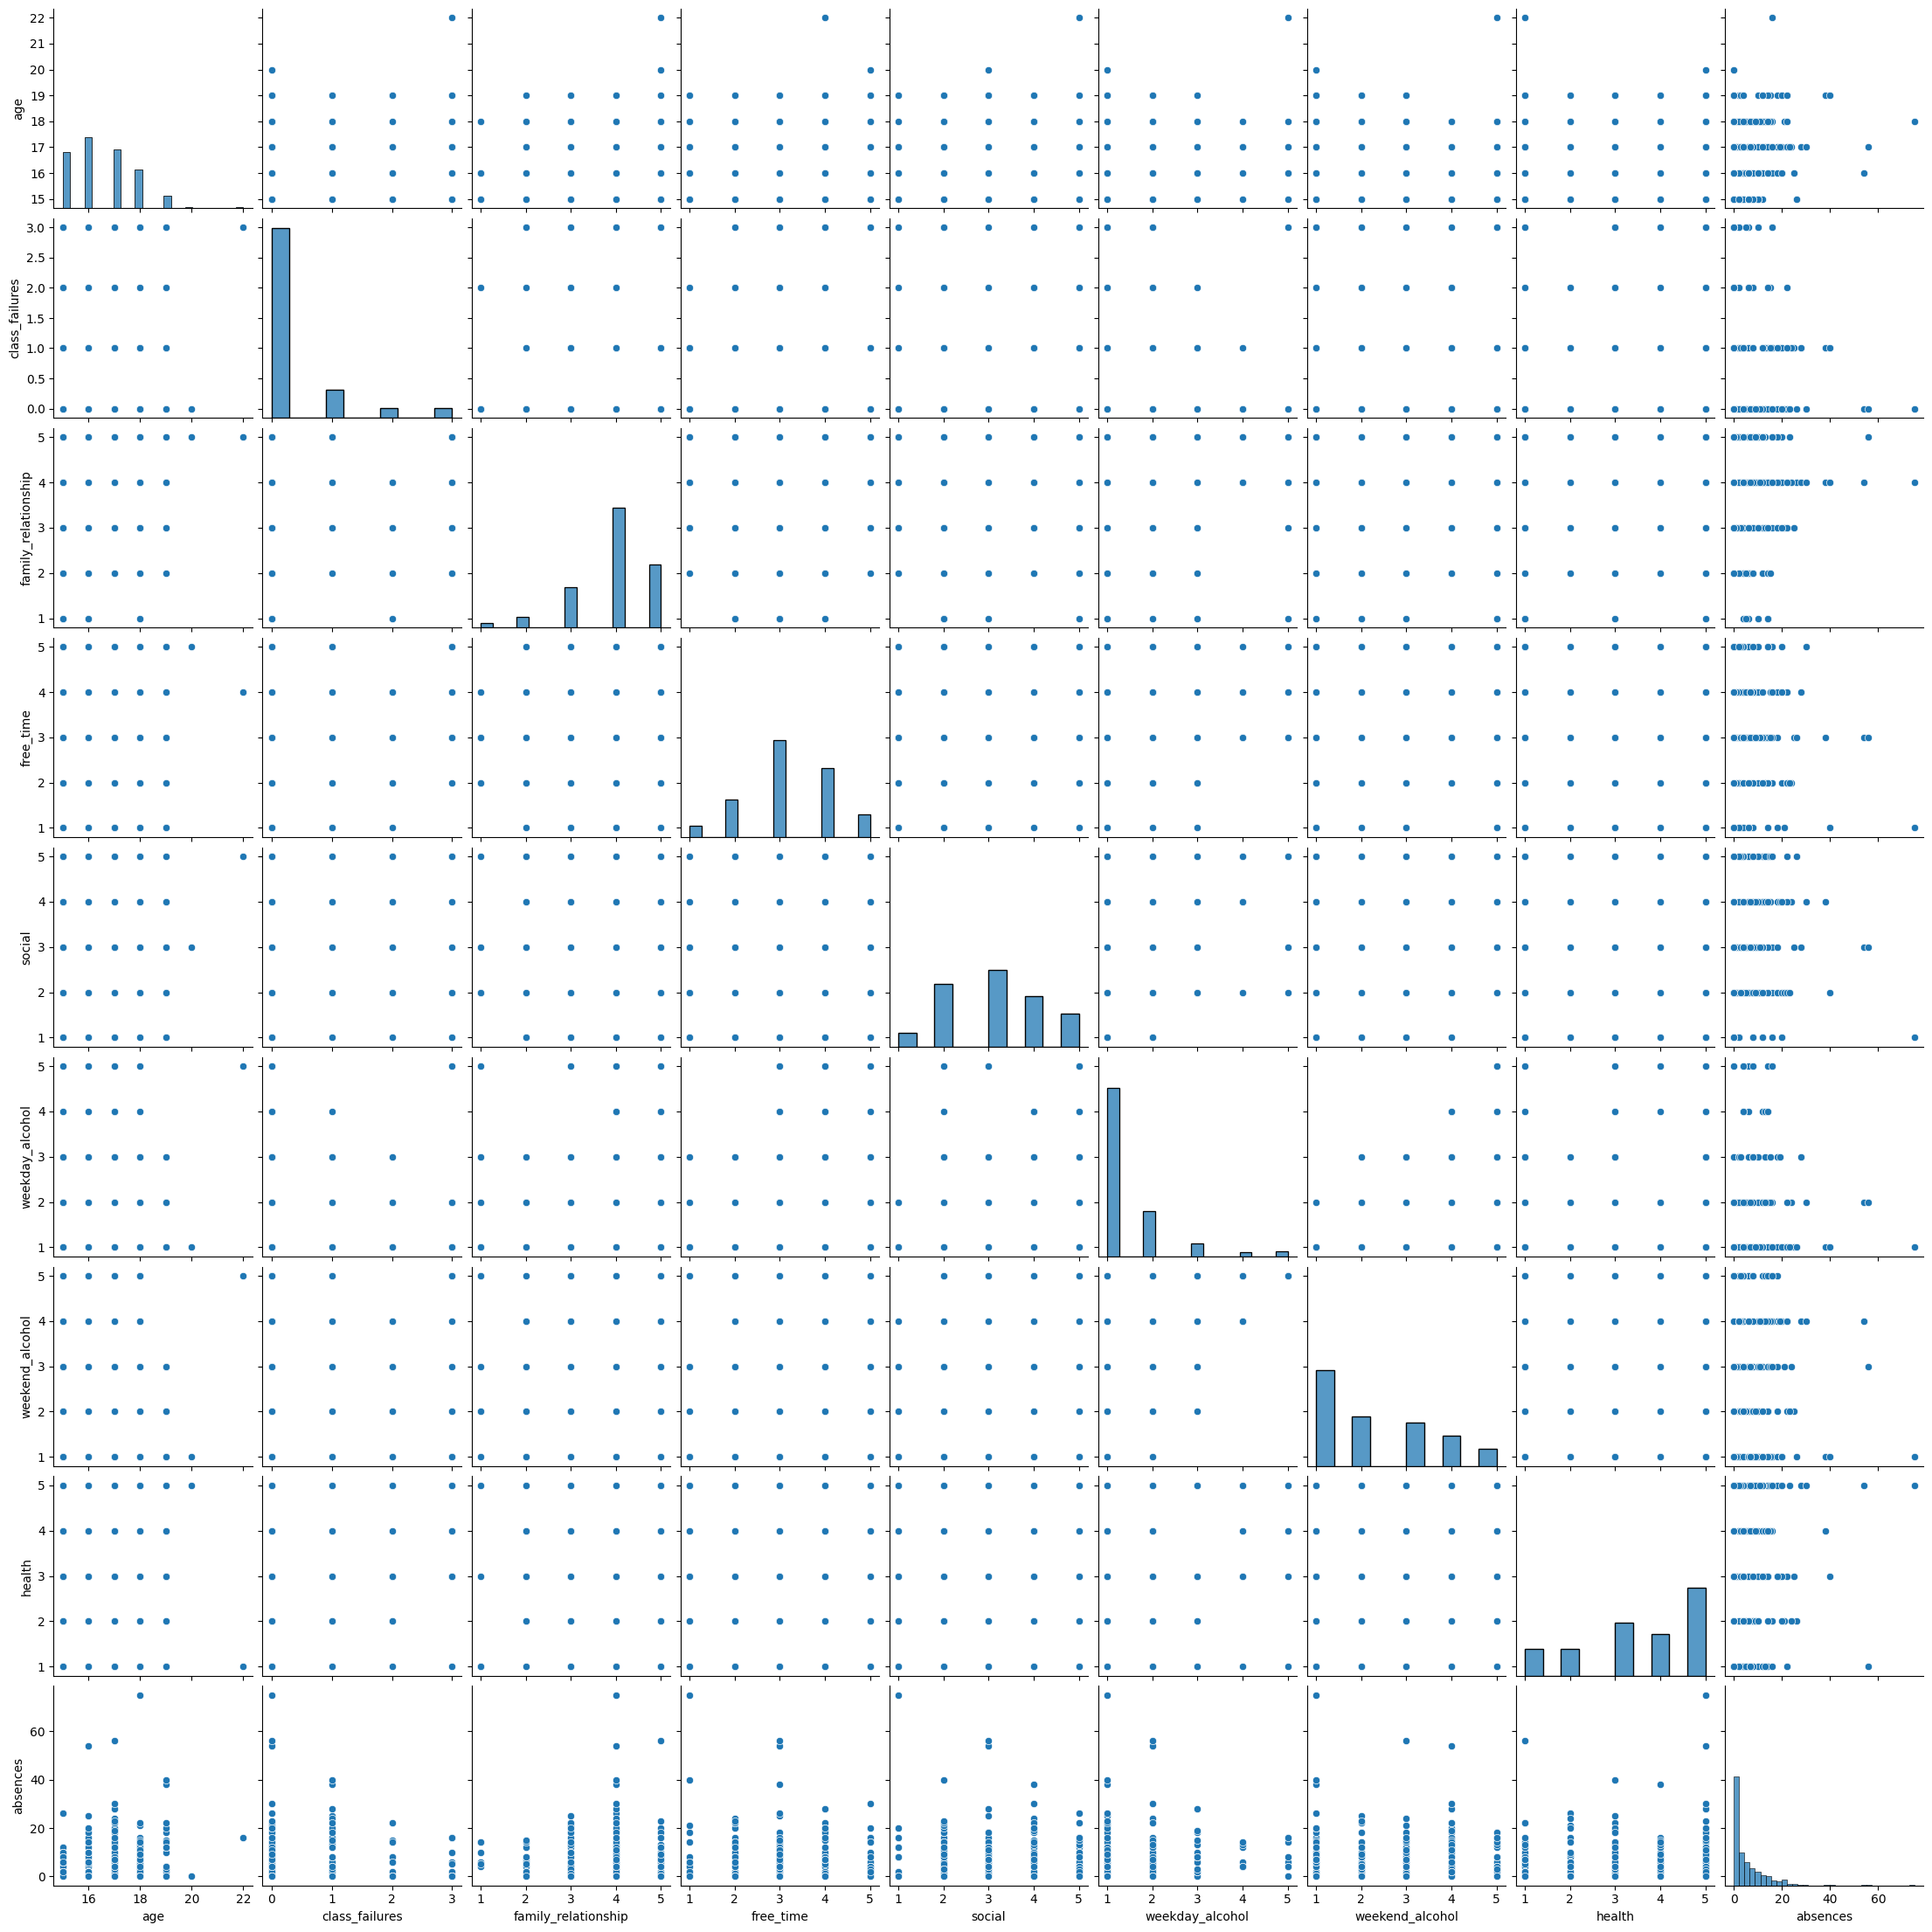

In [7]:
# Now, we would like to create a pair plot on all the numerical variables
df_numerical = df_subset[['age', 'class_failures','family_relationship','free_time', 'social', 'weekday_alcohol','weekend_alcohol','health','absences']]
sns.pairplot(data=df_numerical)

### Pairwise Scatterplot Results
1. Because most of the numerical values only have interger values, the pairplots between two variables are grids. 
2. It seems that there are not significant outliers in most of the variables except for absences. A few outliers exist with high values (over 40) of absences. 


### Dendrograms for Outlier Detection

Next, we would like to detect high-dimensional outliers with single-linkage dendrograms. The single-linkage dendrogram algorithm is more likely to detect outliers than the average-linkage or complete-linkage algorithms.


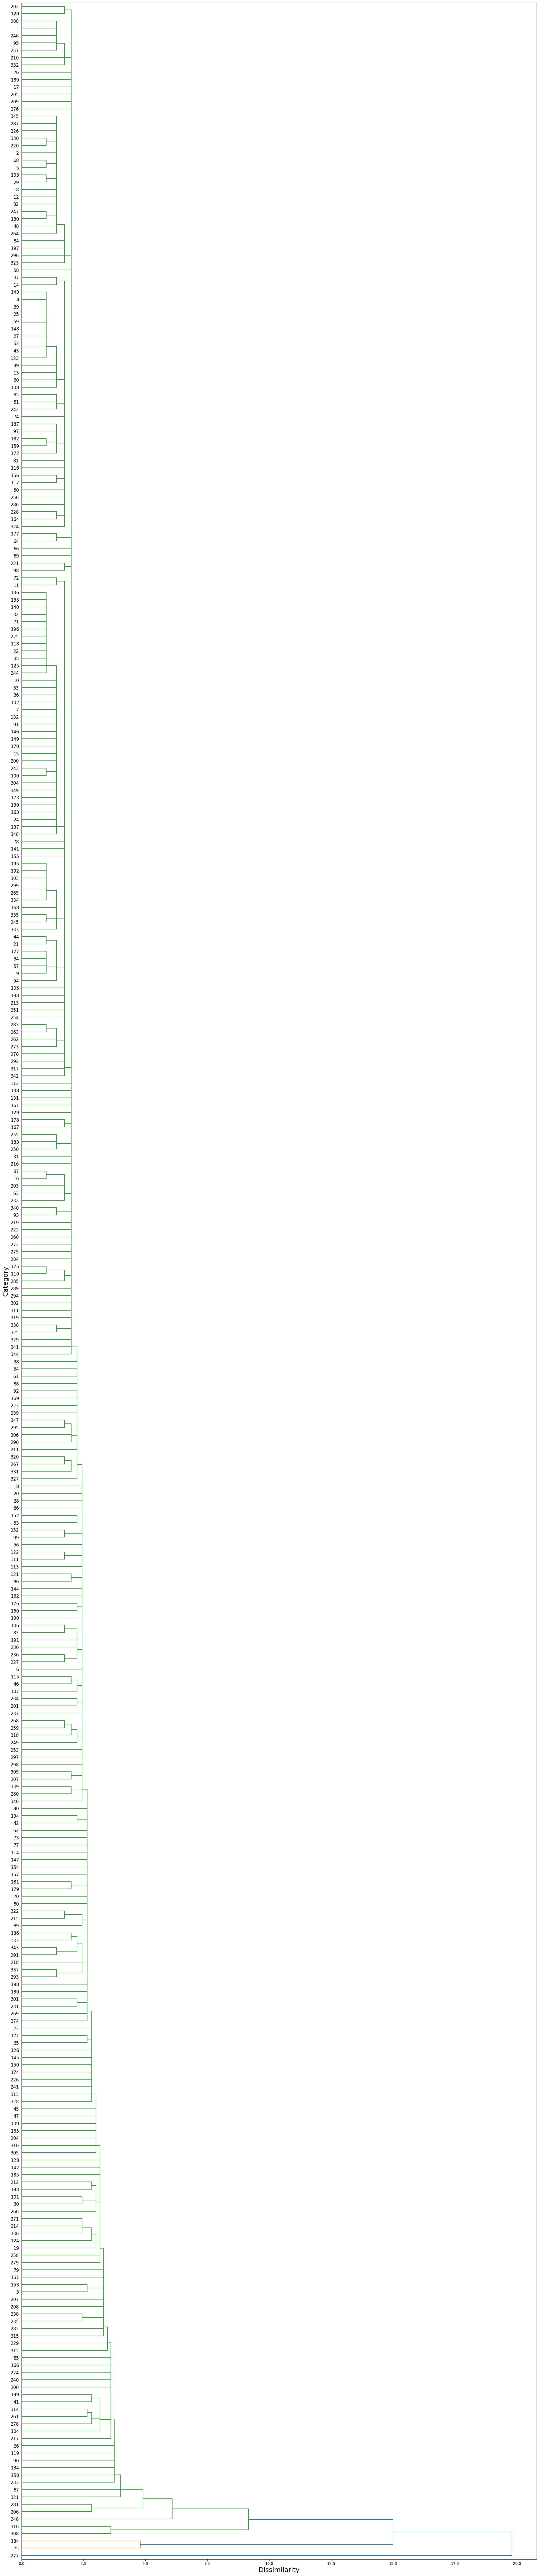

In [10]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

dm = pdist(df_numerical, metric='euclidean')
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(25, 125))
d = dendrogram(Z, orientation='right', labels=df_subset['student_id'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Category', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### Outlier Identification with Single-Linkage Dendrogram Results

According to the dendrogram, the student with ID **227** forms a singleton cluster, and the students with ID **184** and **75** form another subcluster that's separated from the other observations. We consider these three observations as outliers and will drop them for further analysis.

#### Explanation

Because our research goal is to cluster students' final grades based on their private information, the three outliers might bias the interpretation of some predictors on the final clustering results. The pros of dropping them is that we can draw general conclusions from the dataset which meets our research goals. However, the cons are that the final clustering algorithms might not be robust as they do not take into account marginal cases.

### Noise Detection
We will first remove the aforementioned outliers and detect noises for the rest of the dataset.

Then, to check for data noises, we plot the k=2, ..., k=9 distance plot

In [21]:
# Filter df
df_subset_outlier_removal = df_subset[~df_subset['student_id'].isin([184, 75, 277])]

X_numerical = df_subset_outlier_removal[['age', 'class_failures','family_relationship','free_time', 'social', 'weekday_alcohol','weekend_alcohol','health','absences']]
print(X_numerical.shape)

(346, 9)


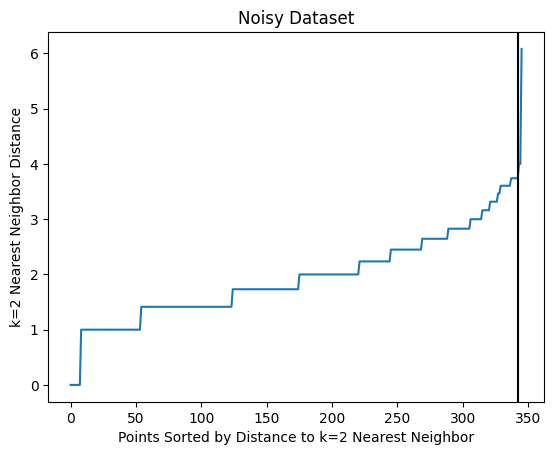

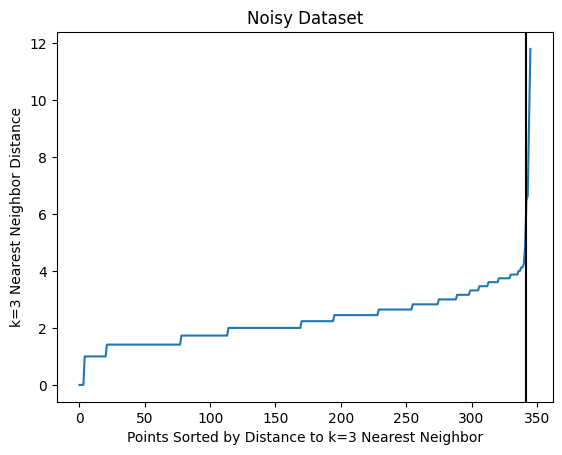

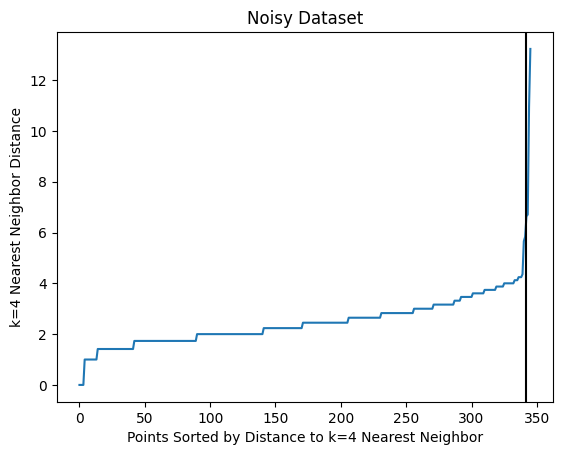

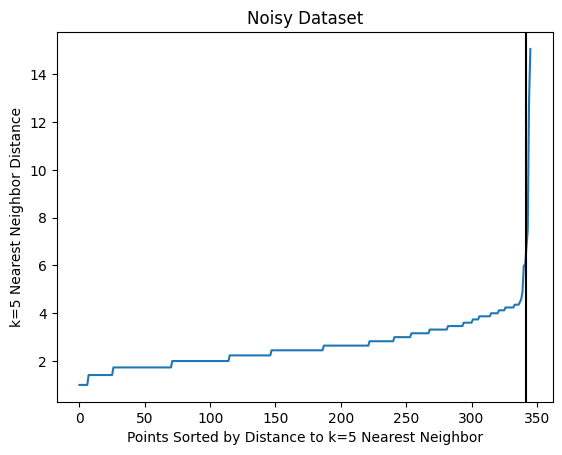

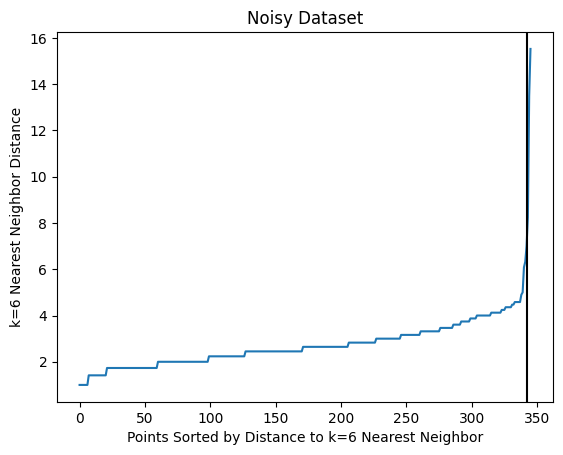

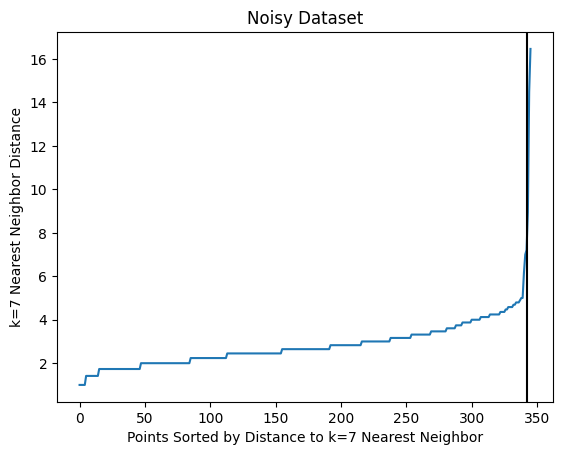

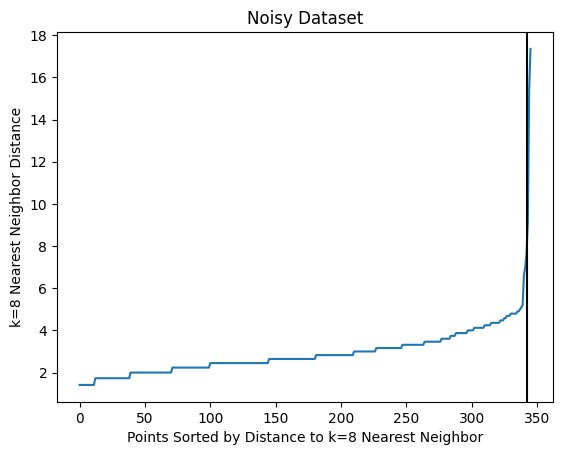

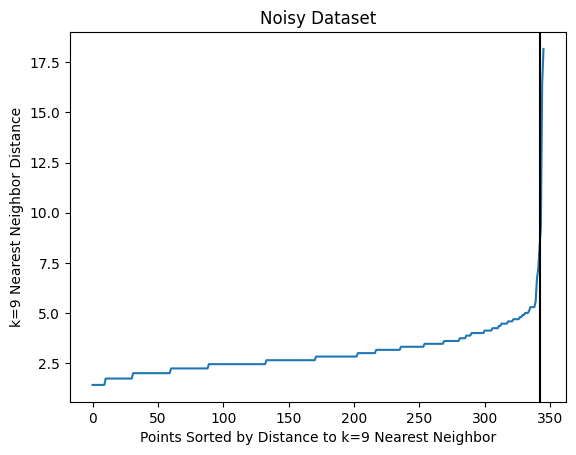

In [23]:
from sklearn.neighbors import NearestNeighbors
#Find the distance of the kth nearest neighbor
for k in range(2,10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_numerical)
    distances, indices = nbrs.kneighbors(X_numerical)

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=342, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

### Noisy Data Conclusion

For k=2...k=9 nearest neighbor plots, there is a dramatic jump in nearest neighbor distances when the number of observations is 342, which indicates that 6 noisy data points exist in the current dataset. Based on the information of noisy data obtained, we can pick reasonable values of $\epsilon$ when using DBSCAN algorithms for clustering. For example, in the k=9 plot, the nearest neighbor value jumps at roughly 7.5, we will set $\epsilon$ as 7.5 if we set minpts as 9 in the DBSCAN algorithm.

## 4. Basic Descriptive Analytics

## 5. Scaling Decisions

## 6. Clusterability and Clustering Structure

## 7. Clustering Algorithm Selection Motivation

## 8. Clustering Algorithm Practical Considerations

## 9. Clustering Algorithm #1



## 10. Clustering Algorithm #2

## 11. Discussion

## 12. Conclusion

## References